# Classifier NNs

## NNs summary
- **Input: an uncertainty realization vector.**
- **Output: a label vector with multiple choices.**



- NNs components
    - Dense
    - BatchNormalization
    - DropOut
    - SoftMax

- Optimizer
    - Adam

- Loss
    - BinaryCrossEntropy

- Metric
    - Accuracy [%]

In [1]:
import pickle
import pprint
from sklearn.model_selection import train_test_split
from os import path

from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

## prepare dataset

In [2]:
test_cases = [
    'pglib_opf_case24_ieee_rts.pickle',
    'pglib_opf_case30_ieee.pickle',
    'pglib_opf_case57_ieee.pickle',
    'pglib_opf_case73_ieee_rts.pickle',
    'pglib_opf_case89_pegase.pickle',
    'pglib_opf_case118_ieee.pickle',
    'pglib_opf_case162_ieee_dtc.pickle',
    'pglib_opf_case179_goc.pickle',
    'pglib_opf_case200_tamu.pickle',
    'pglib_opf_case240_pserc.pickle',
    'pglib_opf_case300_ieee.pickle',
    'pglib_opf_case500_tamu.pickle',
    'pglib_opf_case588_sdet.pickle',
#     'pglib_opf_case1354_pegase.pickle',
#     'pglib_opf_case1888_rte.pickle',
#     'pglib_opf_case1951_rte.pickle',
#     'pglib_opf_case2000_tamu.pickle'
]

In [3]:
# choose a dataset
case_idx = 12
file_dir = path.join('./datasets/', test_cases[case_idx])

In [4]:
infile = open(file_dir,'rb')
dataset = pickle.load(infile)
infile.close()

In [5]:
# train & test
x_train, x_test, y_train, y_test = train_test_split(dataset['x'],
                                                    dataset['y'],
                                                    test_size=0.2,
                                                    random_state=19)
# train & validation
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=19)

In [6]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [7]:
print((x_train.shape, y_train.shape))
print((x_val.shape, y_val.shape))
print((x_test.shape, y_test.shape))

((32000, 588), (32000, 977))
((8000, 588), (8000, 977))
((10000, 588), (10000, 977))


## Set a Classifier Model

In [8]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [9]:
inputs = keras.Input(shape=(x_train.shape[1], ), name='uncertainty_realization')

x = layers.Dense(x_train.shape[1], activation='relu', name='dense_1')(inputs)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.Dropout(rate=0.2, name='dropout_1')(x)

x = layers.Dense(x_train.shape[1]*2, activation='relu', name='dense_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.Dropout(rate=0.2, name='dropout_2')(x)

x = layers.Dense(y_train.shape[1], activation='relu', name='dense_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.Dropout(rate=0.2, name='dropout_3')(x)

outputs = layers.Dense(y_train.shape[1], activation='sigmoid', name='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="multi-label-classification")

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=['binary_accuracy', 'binary_crossentropy'])

In [11]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [12]:
model.summary()

Model: "multi-label-classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
uncertainty_realization (Inp [(None, 588)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 588)               346332    
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 588)               2352      
_________________________________________________________________
dropout_1 (Dropout)          (None, 588)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1176)              692664    
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 1176)              4704      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1176

### Train the Model

In [13]:
print('> Fit model on training data')
history = model.fit(
    x_train,
    y_train,
    batch_size=128,
    epochs=5,
    validation_data=(x_val, y_val),
    callbacks=[tensorboard_callback])

> Fit model on training data
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 8s 248us/sample - loss: 0.1741 - binary_accuracy: 0.9300 - binary_crossentropy: 0.1741 - val_loss: 0.0029 - val_binary_accuracy: 1.0000 - val_binary_crossentropy: 0.0029
Epoch 2/5
32000/32000 [==============================] - 8s 243us/sample - loss: 0.0019 - binary_accuracy: 1.0000 - binary_crossentropy: 0.0019 - val_loss: 8.4969e-04 - val_binary_accuracy: 1.0000 - val_binary_crossentropy: 8.4969e-04
Epoch 3/5
32000/32000 [==============================] - 8s 261us/sample - loss: 6.8756e-04 - binary_accuracy: 1.0000 - binary_crossentropy: 6.8756e-04 - val_loss: 3.3870e-04 - val_binary_accuracy: 1.0000 - val_binary_crossentropy: 3.3870e-04
Epoch 4/5
32000/32000 [==============================] - 9s 293us/sample - loss: 3.3782e-04 - binary_accuracy: 1.0000 - binary_crossentropy: 3.3782e-04 - val_loss: 1.8549e-04 - val_binary_accuracy: 1.0000 - val_binary

In [14]:
pp = pprint.PrettyPrinter(indent=4)
print('> History dict:')
pp.pprint(history.history)

> History dict:
{   'binary_accuracy': [0.9299557, 0.9999946, 0.9999964, 0.99999994, 1.0],
    'binary_crossentropy': [   0.17413752,
                               0.0019238999,
                               0.00068755675,
                               0.00033782164,
                               0.00020192712],
    'loss': [   0.17413743877783416,
                0.0019239002419635654,
                0.0006875565716763959,
                0.0003378217057907023,
                0.00020192710385890677],
    'val_binary_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0],
    'val_binary_crossentropy': [   0.0029243927,
                                   0.00084969,
                                   0.00033869548,
                                   0.00018548922,
                                   0.00011494767],
    'val_loss': [   0.0029243925139307977,
                    0.0008496901015751063,
                    0.00033869549864903094,
                    0.00018548922683112322,
            

In [15]:
%tensorboard --logdir logs

### Evaluate the Model

In [16]:
print('\n# Evaluate')
result = model.evaluate(x_test, y_test)
dict(zip(model.metrics_names, result))


# Evaluate
10000/10000 [==============================] - 2s 186us/sample - loss: 1.1690e-04 - binary_accuracy: 1.0000 - binary_crossentropy: 1.1690e-04


{'loss': 0.00011690368267009035,
 'binary_accuracy': 1.0,
 'binary_crossentropy': 0.000116903684}

### Visualize the prediction

In [17]:
y_pred = model.predict(x_test)

In [18]:
def result_reshape(data):
    result_dim = math.ceil(math.sqrt(len(data)))
    reshaped_data = np.zeros((result_dim, result_dim))

    for i in range(result_dim):
        for j in range(result_dim):
            try:
                reshaped_data[i][j] = data[result_dim * i + j]
            except IndexError:
                reshaped_data[i][j] = -1
    return reshaped_data


def test_vs_pred(y_test, y_pred, data_idx, test_case):
    y_test_reshaped = result_reshape(y_test[data_idx])
    y_pred_reshaped = result_reshape(y_pred[data_idx])

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    fig.suptitle('Active Constraints Distribution: ' + test_case.split('.')[0], size=19, y=0.88)
    axes[0].set_title('y_test', size=15, y=1.03)
    axes[1].set_title('y_pred', size=15, y=1.03)

    sns.heatmap(y_test_reshaped,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'ticks': [-1, 0, 1], 'shrink': .75},
                square=True,
                ax=axes[0])

    sns.heatmap(y_pred_reshaped,
                xticklabels=False,
                yticklabels=False,
                cbar_kws={'ticks': [-1, 0, 1], 'shrink': .75},
                square=True,
                ax=axes[1])

    fig.show()
    file_dir = path.join('./figures/', test_case.split('.')[0] + '.png')
    fig.savefig(file_dir, format='png')

#### Heatmap label:
- **1: active constraint**   
- **0: inactive constraint**
- -1: meaningless data (added cells to make the array as a square matrix)


/Users/jeehyunpark/anaconda3/envs/EE394V/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


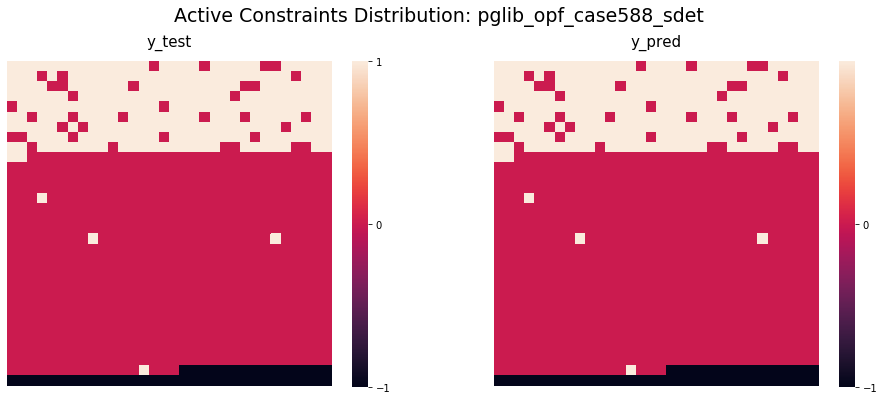

In [19]:
data_idx = 55

test_vs_pred(y_test, y_pred, data_idx, test_cases[case_idx])

In [20]:
y_train

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)